<a href="https://colab.research.google.com/github/Gaurav-S-c/plant-disease-classification/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: big12gaurav
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.21GB/s]

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:

train_df=pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df=pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")


train_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+train_df["image:FILE"]
val_df["image:FILE"]="/content/bean-leaf-lesions-classification/"+val_df["image:FILE"]

train_df.head()

,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [ ]:
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [ ]:
train_df["category"].unique()

array([0, 1, 2])

In [ ]:
print(train_df["category"].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [ ]:
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.tensor(dataframe["category"]).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    img_path=self.dataframe.iloc[idx,0]
    label=self.labels[idx]
    image=Image.open(img_path)
    if self.transform:
      image=(self.transform(image)).to(device)

    return image,label

In [ ]:
train_dataset=CustomImageDataset(dataframe=train_df,transform=transform)
val_dataset=CustomImageDataset(dataframe=val_df,transform=transform)

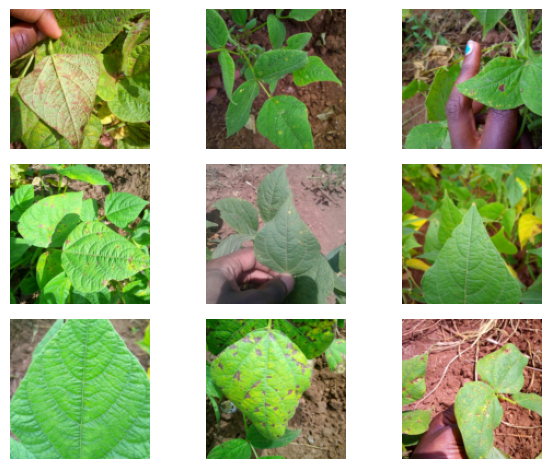

In [ ]:
n_rows=3
n_cols=3

f,axarr=plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image=train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
    axarr[row,col].imshow((image).squeeze().permute(1,2,0))
    axarr[row,col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
LR=1e-3
BATCH_SIZE=4
EPOCHS=15

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
googlenet_model=models.googlenet(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 125MB/s]


In [ ]:
for param in googlenet_model.parameters():
  param.requires_grad=True

In [ ]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
num_classes=len(train_df["category"].unique())
num_classes

3

In [ ]:
googlenet_model.fc=torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [ ]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot=[]
total_acc_train_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_loss_train=0

  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs=googlenet_model(inputs)
    train_loss = loss_fn(outputs,labels)
    total_loss_train +=train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train +=train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
  print(f"Epoch {epoch +1}/{EPOCHS} | Train_Loss:{round(total_loss_train/1000,4)} | Train_Accuracy: {round(total_acc_train/train_dataset.__len__()*100,4)} %")


Epoch 1/15 | Train_Loss:0.2104 | Train_Accuracy: 64.9903 %
Epoch 2/15 | Train_Loss:0.1796 | Train_Accuracy: 71.1799 %
Epoch 3/15 | Train_Loss:0.1385 | Train_Accuracy: 79.4004 %
Epoch 4/15 | Train_Loss:0.1167 | Train_Accuracy: 83.6557 %
Epoch 5/15 | Train_Loss:0.0968 | Train_Accuracy: 87.4275 %
Epoch 6/15 | Train_Loss:0.0972 | Train_Accuracy: 87.6209 %
Epoch 7/15 | Train_Loss:0.1066 | Train_Accuracy: 85.1064 %
Epoch 8/15 | Train_Loss:0.0601 | Train_Accuracy: 92.6499 %
Epoch 9/15 | Train_Loss:0.0665 | Train_Accuracy: 91.6828 %
Epoch 10/15 | Train_Loss:0.0465 | Train_Accuracy: 94.1006 %
Epoch 11/15 | Train_Loss:0.0553 | Train_Accuracy: 92.3598 %
Epoch 12/15 | Train_Loss:0.0526 | Train_Accuracy: 93.2302 %
Epoch 13/15 | Train_Loss:0.04 | Train_Accuracy: 94.7776 %
Epoch 14/15 | Train_Loss:0.0442 | Train_Accuracy: 93.2302 %
Epoch 15/15 | Train_Loss:0.0544 | Train_Accuracy: 92.4565 %


In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test=0

  for input,labels in val_loader:
    prediction = googlenet_model(input)

    acc=(torch.argmax(prediction,axis=1)==labels).sum().item()
    total_acc_test+=acc

In [ ]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

93.23


### Inference

In [ ]:
with open("/content/bean-leaf-lesions-classification/classname.txt", "r") as f:
    class_names = [line.strip() for line in f]

print("Class names:", class_names)

Class names: ['healthy', 'angular_leaf_spot', 'bean_rust']


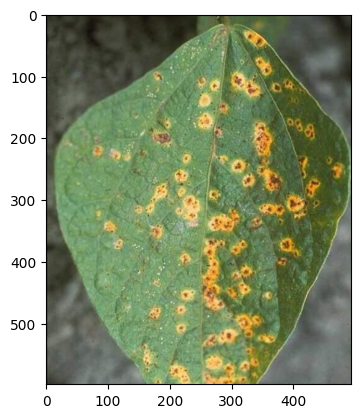


Prediction:



'bean_rust'

In [ ]:
def predict_image(image_path):
  image=Image.open(image_path).convert('RGB')
  image=transform(image).to(device)

  googlenet_model.eval()
  with torch.no_grad():
    output=googlenet_model(image.unsqueeze(0))
    output=torch.argmax(output,axis=1).item()
    return class_names[output]

image=Image.open("/content/d7642e7a-f7b3-4cdd-93b4-1765f42cc33c.jpg")
plt.imshow(image)
plt.show()

print()
print("Prediction:\n")
predict_image("/content/d7642e7a-f7b3-4cdd-93b4-1765f42cc33c.jpg")

In [ ]:
torch.save(googlenet_model.state_dict(), "model_state.pth")

In [ ]:
from google.colab import files
files.download("/content/bean-leaf-lesions-classification/classname.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>